In [1]:
include("notebook_preamble.jl");

In [2]:
using SymPy;
include("TransverseIsingModels.jl")
using .TransverseIsingModels
TIM = TransverseIsingModels;

# Computation of jump operators

In [3]:
⊗ₖ = kron;

In [4]:
const σ0 = [1 0; 0 1];
const σx = [0 1; 1 0];
const σy = [0 -im; im 0];
const σz = [1 0; 0 -1];
const σp = [0 1; 0 0];
const σm = [0 0; 1 0];

In [5]:
function symeigen(H)
    symeig = H.eigenvects()
    vals, vecs = eltype(H)[], []
    for (λ, _, vs) in symeig
        for v in vs
            push!(vals, λ)
            push!(vecs, vec(v))
        end
    end
    vals, vecs
end;

In [6]:
function addentry!(dict, key, value; isequal=isequal)
    for k in keys(dict)
        if isequal(k, key)
            push!(dict[k], value)
            return dict
        end
    end
    dict[key] = [value]
    dict
end;

In [7]:
firstvalue(i, (x, y)) = x
lastvalue(i, (x, y)) = y
function dictby(A; isequal=isequal, keyof=firstvalue, valof=lastvalue)
    i0, x0 = 1, first(A)
    k0, v0 = keyof(i0, x0), valof(i0, x0)
    dict = Dict(k0 => typeof(v0)[])
    dict = Dict()
    for (i, x) in enumerate(A)
        k, v = keyof(i, x), valof(i, x)
        addentry!(dict, k, v, isequal=isequal)
    end
    dict
end;

In [8]:
import QuantumOpticsBase.projector
projector(ψ::AbstractVector) = ψ * ψ';

In [9]:
function incentry!(dict, key; isequal=isequal)
    for k in keys(dict)
        if isequal(k, key)
            dict[k] += 1
            return dict
        end
    end
    dict[key] = 1
    dict
end;

In [10]:
function combinejumps(Js)
    d = Dict()
    for J in Js
        incentry!(d, J)
    end
    [√(one(eltype(J)) * N)*J for (J, N) in d]
end;

In [11]:
function jumps(vals, vecs, As; combine=true, isequal=isequal)
    eigendict = dictby(zip(vals, vecs))
    ωs = dictby(((E2 - E1, (E1, E2)) for E1 in keys(eigendict) for E2 in keys(eigendict)), isequal=isequal)
    Πs = TIM.projectors(eigendict)
    Jωs = dictmap(ΔEs -> filter(x -> !isequal(x, zero(x)), [simplify.(sum(Πs[E1]*A*Πs[E2] for (E1, E2) in ΔEs)) for A in As]), ωs)
    combine ? dictmap(combinejumps, Jωs) : Jωs
end
dipolejumps(vals, vecs; kwargs...) = jumps(vals, vecs,
    [σx ⊗ₖ σ0,  σy ⊗ₖ σ0,  σz ⊗ₖ σ0, σ0 ⊗ₖ σx,  σ0 ⊗ₖ σy,  σ0 ⊗ₖ σz];
    kwargs...);

In [12]:
@vars s1p=>"σ₁⁺" s1m=>"σ₁⁻" commutative=false
@vars s2p=>"σ₂⁺" s2m=>"σ₂⁻" commutative=false
@vars s1x=>"σ₁ˣ" s2x=>"σ₂ˣ" commutative=false
@vars s1y=>"σ₁ʸ" s2y=>"σ₂ʸ" commutative=false
@vars s1z=>"σ₁ᶻ" s2z=>"σ₂ᶻ" commutative=false
@vars n1 =>"n₁"   n2=>"n₂"  commutative=false
@vars g d real=true;

In [13]:
spinops = [s1p, s1m, s2p, s2m, s1x, s2x, s1y, s2y, s1z, s2z, n1, n2];
_symspinop = cat([n1 s1p; s1m (1 - n1)], [n2 s2p; s2m (1 - n2)], dims=3)
_dummy_spinop = Dict(s => sympy.Dummy(s.name) for s in spinops);
site_collect_ops(siteops) = push!([_dummy_spinop[op] for op in siteops], 1)
_collect_ops = [a * b for a in site_collect_ops([s1p, s1m, n1]) for b in site_collect_ops([s2p, s2m, n2])];

In [14]:
u, v, w = Wild(:u), Wild(:v), Wild(:w);

In [15]:
symspinop(l, r, i) = _symspinop[l+1, r+1, i];
function jumpsimplify(J)
    s = mapreduce(+, CartesianIndices(J)[J .!= 0]) do I
        x = J[I]
        i, j = Tuple(I - CartesianIndex(1, 1))
        x * symspinop(i÷2, j÷2, 1) * symspinop(i%2, j%2, 2)
    end
    s = subs(expand(s), √(g^2 + 1) => d)
    s = s.simplify()
    s = s.xreplace(_dummy_spinop)
    for op in _collect_ops
        s = s.collect(op)
    end
    s.simplify()
end;

In [16]:
=>ₛ(a, b) = _dummy_spinop[a] => b
thesis_latex(J) = sympy.latex(J,
        imaginary_unit = "\\im",
        symbol_names = Dict(
            g   =>  "g",
            d   =>  "d",
            n1  =>ₛ "\\opr{n}_1",
            n2  =>ₛ "\\opr{n}_2",
            s1p =>ₛ "\\pauli_1^+",
            s2p =>ₛ "\\pauli_2^+",
            s1m =>ₛ "\\pauli_1^-",
            s2m =>ₛ "\\pauli_2^-",
        ));

In [17]:
function save_jump_latex(path, sJωs)
    open(path, "w") do file
        for (ω, Js) in sJωs
            sω = factor(subs(expand(ω), √(g^2 + 1) => d))
            println(file, thesis_latex(sω))
            println(file, " \\\\")
            for J in Js
                println(file, thesis_latex(J))
                println(file, " \\\\")
            end
            println(file, " \\\\")
        end
    end
end;

## Nondegenerate jump operators

In [18]:
H = -2*(σx ⊗ₖ σx) - g*(σz ⊗ₖ σ0 + σ0 ⊗ₖ σz)

4×4 Array{Sym,2}:
 -2⋅g   0   0   -2
    0   0  -2    0
    0  -2   0    0
   -2   0   0  2⋅g

In [197]:
sJωs = dictmap(Js -> jumpsimplify.(Js), dipolejumps(symeigen(H)...; combine=true))
save_jump_latex("nondegen-jumps.tex", sJωs)

## Degenerate jump operators

In [20]:
H0 = subs.(-2*(σx ⊗ₖ σx) - g*(σz ⊗ₖ σ0 + σ0 ⊗ₖ σz), g => 0)

4×4 Array{Sym,2}:
  0   0   0  -2
  0   0  -2   0
  0  -2   0   0
 -2   0   0   0

In [198]:
sJωs0 = dictmap(Js -> jumpsimplify.(Js), dipolejumps(symeigen(H0)...; combine=true))
save_jump_latex("degen-jumps.tex", sJωs0)

# Liouvillian

## Superoperators

In [444]:
leftmul(A)  = one(A) ⊗ₖ A
rightmul(A) = permutedims(A) ⊗ₖ one(A)
comm(A, B) = A*B - B*A
acomm(A, B) = A*B + B*A
commwith(A) = leftmul(A) - rightmul(A)
acommwith(A) = leftmul(A) + rightmul(A);

In [532]:
nB(ω, β) = 1 / (exp(β*ω) - 1)
γdiv(ω; β) = isapprox(ω, 0, atol=1e-9) ? 0 : ω^3 * (nB(ω, β) + 1)
ℋLSterm(J, S) = S * commwith(J' * J)
ℋLS(Jωs, S; params...) = -im * sum(ℋLSterm(J, S(ω; params...)) for (ω, Js) in Jωs for J in Js)
𝒟term(J, γ) = γ * (leftmul(J) * rightmul(J') - acommwith(J' * J) / 2)
𝒟(Jωs, γ; params...) = sum(𝒟term(J, γ(ω; params...)) for (ω, Js) in Jωs for J in Js);
𝒟LRterm(J, γ) = γ * (leftmul(J) * rightmul(J'))
𝒟LR(Jωs, γ; params...) = sum(𝒟LRterm(J, γ(ω; params...)) for (ω, Js) in Jωs for J in Js);
𝒟Aterm(J, γ) = γ * (- acommwith(J' * J) / 2)
𝒟A(Jωs, γ; params...) = sum(𝒟Aterm(J, γ(ω; params...)) for (ω, Js) in Jωs for J in Js);

In [385]:
function numeigen(H)
    vals, vecs = eigen(H)
    vals, eachcol(vecs)
end

isequalto(atol=1e-9) = (x, y) -> isapprox(x, y, atol=atol)

function unitary_rates(H, dict, γ; params...)
    Jωs = dipolejumps(numeigen(N.(subs.(H, dict)))...;
        combine=true, isequal=isequalto())
    lambham = (x -> isequalto()(x, zero(x)) ? zero(x) : x).(ℋLS(Jωs, γ; params...))
    eigvals(lambham)
end

function dissipation_rates(H, dict, γ; params...)
    Jωs = dipolejumps(numeigen(N.(subs.(H, dict)))...;
        combine=true, isequal=isequalto())
    dissipator = (x -> isequalto()(x, zero(x)) ? zero(x) : x).(𝒟(Jωs, γ; params...))
    eigvals(dissipator)
end;

## Jump operators and commutation

In [397]:
Jωs = dipolejumps(numeigen(-0.5*(σx ⊗ₖ σx) - (σz ⊗ₖ σ0 + σ0 ⊗ₖ σz))...; combine=true, isequal=isequalto())

Dict{Float64,Array{Array{Complex{Float64},2},1}} with 9 entries:
  0.0      => Array{Complex{Float64},2}[[0.941176+0.0im 0.0+0.0im 0.0+0.0im 0.2…
  1.0      => Array{Complex{Float64},2}[[0.0+0.0im 0.0+0.0im 0.0+0.0im 0.0+0.0i…
  -1.56155 => Array{Complex{Float64},2}[[0.0+0.0im 0.0-0.0531695im 0.0+0.053169…
  1.56155  => Array{Complex{Float64},2}[[0.0+0.0im 0.55317+0.0im 0.55317+0.0im …
  -1.0     => Array{Complex{Float64},2}[[0.0+0.0im 0.0+0.0im 0.0+0.0im 0.0+0.0i…
  2.56155  => Array{Complex{Float64},2}[[0.0+0.0im -0.431902+0.0im 0.431902+0.0…
  4.12311  => Array{Complex{Float64},2}[[0.0415945+0.0im 0.0+0.0im 0.0+0.0im -0…
  -2.56155 => Array{Complex{Float64},2}[[0.0+0.0im -0.0531695+0.0im -0.0531695+…
  -4.12311 => Array{Complex{Float64},2}[[0.0415945+0.0im 0.0+0.0im 0.0+0.0im 0.…

In [468]:
sum(sum(abs.(comm(J1, J2' * J2))) for Js1 in values(Jωs) for J1 in Js1 for Js2 in values(Jωs) for J2 in Js2)

386.2423374904549

In [469]:
sum(sum(abs.(comm(J1' * J1, J2' * J2))) for Js1 in values(Jωs) for J1 in Js1 for Js2 in values(Jωs) for J2 in Js2)

1.6404874069514222e-14

Why do the unitary (Lamb-shift or other) and dissipative superoperators commute?

In [561]:
lambham = ℋLS(Jωs, (ω; kwargs...) -> rand(), β = 1.0) # Arbitrary S(ω)
diss = 𝒟(Jωs, γdiv, β = 1.0)
disslr = 𝒟LR(Jωs, γdiv, β = 1.0)
dissa = 𝒟A(Jωs, γdiv, β = 1.0);

In [726]:
diss' - diss .|> abs |> sum

335.9999999999999

In [727]:
disslr' - disslr .|> abs |> sum

335.9999999999999

The LR-part of the dissipator is not Hermitian.

In [562]:
comm(lambham, diss) .|> abs |> sum

2.470355720938867e-13

In [563]:
comm(lambham, dissa) .|> abs |> sum

8.810227413606782e-14

The Lamb-shift and dissipative superoperators commute.

In [732]:
(im*lambham)' - (im*lambham) .|> abs |> sum

0.0

The full Lamb-shift superoperator is Hermitian, as expected.

In [564]:
comm(lambham, disslr) .|> abs |> sum

1.6518183426973484e-13

In [560]:
comm(lambham - im*commwith(-0.5*(σx ⊗ₖ σx) - (σz ⊗ₖ σ0 + σ0 ⊗ₖ σz)), diss) .|> abs |> sum

0.8357140801660767

In [489]:
Js = vcat(values(Jωs)...);

In [509]:
Ts = [rand(4, 4) for _ in 1:(length(Js) / 2)]
# Ts = (T -> (T + T') / 2).(Ts)
Ts = [Ts; (T -> T').(Ts)];

In [513]:
(Ts -> sum(abs, comm(sum(T -> commwith(T' * T), Ts), sum(T -> leftmul(T) * rightmul(T') - acommwith(T)/2, Ts)))).([Ts, Js])

2-element Array{Float64,1}:
 6171.690419417579
    8.384139082478663e-14

In [545]:
(Ts -> [sum(abs, leftmul(T1'*T1*T2)*rightmul(T2') - leftmul(T2)*rightmul(T2'*T1'*T1)
            - leftmul(T2*T1'*T1)*rightmul(T2') + leftmul(T2)*rightmul(T1'*T1*T2'))
        for (T1, T2) in Iterators.product(Ts, Ts)])(Js)

24×24 Array{Float64,2}:
 2.57592e-46  2.57592e-46  7.66335e-47  …  5.81231      2.5245e-17
 2.57592e-46  2.57592e-46  7.66335e-47     5.81231      2.5245e-17
 1.04492e-15  1.04492e-15  4.44089e-16     3.08779      0.0
 1.04492e-15  1.04492e-15  4.44089e-16     3.08779      0.0
 7.52229e-16  7.52229e-16  2.22045e-16     2.33603e-16  2.24972e-18
 7.31412e-16  7.31412e-16  1.11022e-16  …  2.21643e-16  2.35814e-18
 1.24939e-15  1.24939e-15  3.33067e-16     2.69106e-16  4.44523e-18
 1.37602e-15  1.37602e-15  3.33067e-16     2.26311e-16  7.56231e-18
 1.37082e-15  1.37082e-15  4.06767e-16     7.02366e-16  6.61415e-18
 7.3228e-16   7.3228e-16   2.56396e-16     2.70211e-16  2.87291e-18
 1.36214e-15  1.36214e-15  2.39761e-16  …  2.5832e-16   7.58725e-18
 4.60795e-16  4.60795e-16  1.11207e-16     8.98917e-17  4.19053e-18
 1.04492e-15  1.04492e-15  4.44089e-16     3.08779      0.0
 1.04492e-15  1.04492e-15  4.44089e-16     3.08779      0.0
 4.9549e-16   4.9549e-16   1.11022e-16     2.20384e-16  4.

In [531]:
sum(abs.(lambham*diss - diss*lambham))

3.087012298211889e-13

In [387]:
unitary_rates(-g*(σx ⊗ₖ σx) - Sym(1)*(σz ⊗ₖ σ0 + σ0 ⊗ₖ σz), g => 0.5, (ω; kwargs...) -> ω, β = β)

16-element Array{Complex{Float64},1}:
  -7.105427357601002e-15 + 17.46256500261599im
  -5.329070518200751e-15 + 12.731282501307998im
  -9.227884241529766e-16 - 8.000000000000004im
   -4.98851266322101e-16 - 17.462565002615975im
  -3.551676818936971e-16 + 5.018048615358172e-17im
 -1.1092188935359755e-16 + 8.000000000000005im
 -2.0328790734103208e-20 + 12.73128250130797im
   6.809297825563993e-18 - 4.7312825013079856im
  3.2504381131115423e-16 + 4.731282501307987im
  4.1881535493684293e-16 - 2.6582660060945874e-16im
    4.44090998525497e-16 + 4.73128250130799im
   8.925966649376186e-16 - 4.731282501307985im
  1.0009190718918834e-15 - 1.8267373944428236e-16im
  1.0122187765602485e-15 + 1.4434433083475654e-16im
   3.552713678800501e-15 - 12.731282501307987im
   6.862566070964249e-15 - 12.731282501308im

In [389]:
dissipation_rates(-g*(σx ⊗ₖ σx) - Sym(1)*(σz ⊗ₖ σ0 + σ0 ⊗ₖ σz), g => 0.5, γdiv, β = β)

16-element Array{Complex{Float64},1}:
    -49.47726750741191 + 0.0im
    -42.54639781775014 + 0.0im
   -42.546397817750005 + 0.0im
    -35.61552812808825 + 0.0im
    -28.54639781775007 + 0.0im
   -28.546397817750066 + 0.0im
   -24.738633753705994 + 0.0im
   -24.738633753705983 + 0.0im
     -21.6155281280883 + 0.0im
   -21.615528128088297 + 0.0im
   -17.807764064044154 + 0.0im
    -17.80776406404414 + 0.0im
    -7.615528128088305 + 0.0im
    -3.807764064044161 + 0.0im
   -3.8077640640441555 + 0.0im
 8.741082105013604e-15 + 0.0im

## Dissipator eigenvalue plots

In [566]:
import Plots.PlotMeasures: pt;

In [627]:
rubric = RGB(0.7, 0.05, 0.0);

In [713]:
function plot_varising_rates(g0s, β; kwargs...)
    maxrates_ising = [real(dissipation_rates(-g*(σx ⊗ₖ σx) - (σz ⊗ₖ σ0 + σ0 ⊗ₖ σz), g => g0, γdiv, β = β)) for g0 in g0s]
    maxrates_free = real(dissipation_rates(-Sym(1)*(σz ⊗ₖ σ0 + σ0 ⊗ₖ σz), g => 1.0, γdiv, β = β))[1:end-1];

    plot(g0s, -hcat(maxrates_ising...)'[:,1:end-1],
        title=L"\beta = %$β",
        color=:black,
        alpha=0.25;
        kwargs...)

    scatter!(repeat([0.9*g0s[1]], length(maxrates_free)), -maxrates_free,
        marker=(:rtriangle, 2, rubric),
        markerstrokecolor=rubric
    )
end

function plot_varfield_rates(g0s, β; kwargs...)
    maxrates_ising = [real(dissipation_rates(-(σx ⊗ₖ σx) - g*(σz ⊗ₖ σ0 + σ0 ⊗ₖ σz), g => g0, γdiv, β = β)) for g0 in g0s]
    maxrates_free = real(dissipation_rates(-Sym(1)*(σx ⊗ₖ σx), g => 1.0, γdiv, β = β))[1:end-1];

    plot(g0s, -hcat(maxrates_ising...)'[:,1:end-1],
        title=L"\beta = %$β",
        color=:black,
        alpha=0.25;
        kwargs...)

    scatter!(repeat([0.9*g0s[1]], length(maxrates_free)), -maxrates_free,
        marker=(:rtriangle, 2, rubric),
        markerstrokecolor=rubric
    )
end

function plot_varrel_rates(g0s, β; kwargs...)
    maxrates_ising = [real(dissipation_rates(-(1 - g)*(σx ⊗ₖ σx) - g*(σz ⊗ₖ σ0 + σ0 ⊗ₖ σz), g => g0, γdiv, β = β)) for g0 in g0s]
    maxrates_free_ising = real(dissipation_rates(-Sym(1)*(σx ⊗ₖ σx), g => 1.0, γdiv, β = β))[1:end-1];
    maxrates_free_trans = real(dissipation_rates(-Sym(1)*(σz ⊗ₖ σ0 + σ0 ⊗ₖ σz), g => 1.0, γdiv, β = β))[1:end-1];

    plot(g0s, -hcat(maxrates_ising...)'[:,1:end-1],
        title=L"\beta = %$β",
        color=:black,
        alpha=0.25;
        kwargs...)

    scatter!(repeat([g0s[1] - 2e-2], length(maxrates_free_ising)), -maxrates_free_ising,
        marker=(:rtriangle, 2, rubric),
        markerstrokecolor=rubric
    )
    scatter!(repeat([g0s[end] + 2e-2], length(maxrates_free_trans)), -maxrates_free_trans,
        marker=(:ltriangle, 2, rubric),
        markerstrokecolor=rubric
    )
end

function plot_scaled_rates(g0s, β; post=identity, kwargs...)
#     maxrates_ising = [real(dissipation_rates(g*(-(σx ⊗ₖ σx) - (σz ⊗ₖ σ0 + σ0 ⊗ₖ σz)), g => g0, γdiv, β = β)) for g0 in g0s]
    maxrates_ising = [real(dissipation_rates(g*(-0*(σx ⊗ₖ σx) - (σz ⊗ₖ σ0 + σ0 ⊗ₖ σz)), g => g0, γdiv, β = β)) for g0 in g0s]

    plot(g0s, post.(-hcat(maxrates_ising...)'[:,1:end-1]),
        title=L"\beta = %$β",
        color=:black,
        alpha=0.25;
        kwargs...)
end

function rate_plot(g0s, βs, f; kwargs...)
    plot([f(g0s, β) for β in βs]...,
        layout=(4, 3),
        size=(800, 2*600),
        xlabel="Ising interaction strength",
        ylabel="Nonzero dissipator eigenvalues (negated)",
        top_margin=6pt,
        bottom_margin=6pt,
        xscale=:log10,
        yscale=:log10,
#         link=:all,
        key=false;
        kwargs...
    )
end;

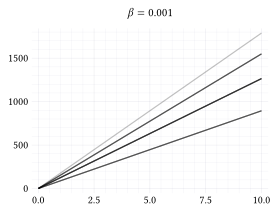

In [719]:
plot_scaled_rates(range(1e-2, 1e1, length=64), 1e-3, post=sqrt, key=false)

In [676]:
g0s = 10 .^ range(-2, 1, length=64)
βs = [1e-2, 2e-2, 5e-2, 1e-1, 2e-1, 5e-1, 1e0, 2e0, 5e0, 1e1, 2e1, 5e1];

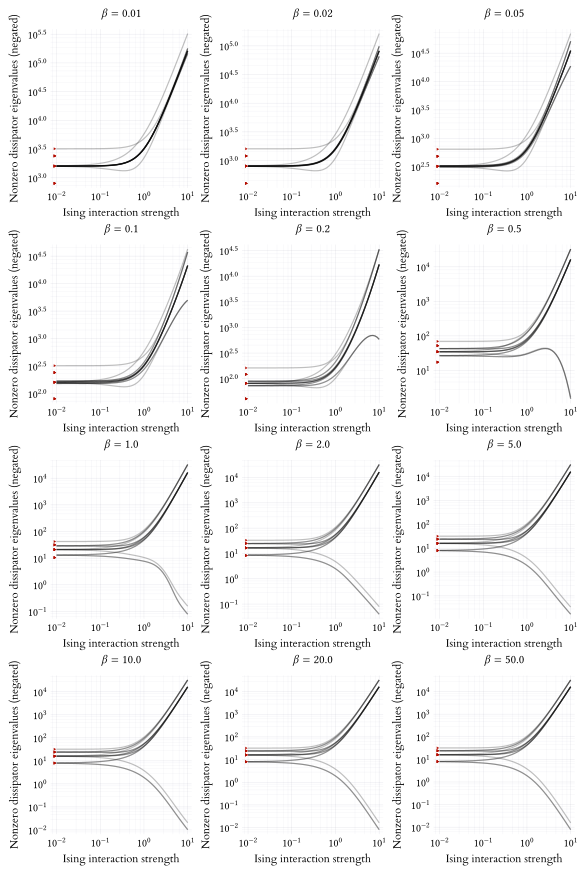

In [677]:
rate_plot(g0s, βs, plot_varising_rates, xlabel="Ising interaction strength")

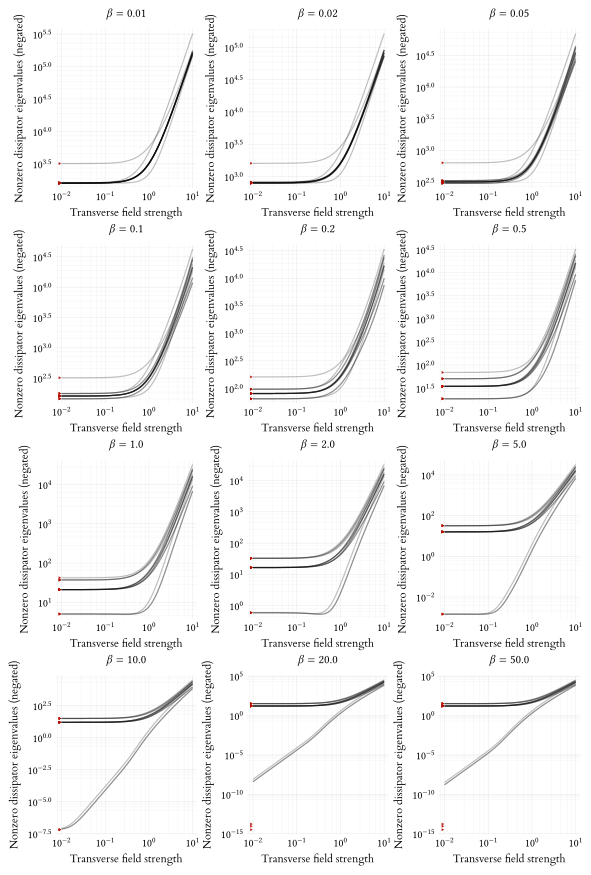

In [678]:
rate_plot(g0s, βs, plot_varfield_rates, xlabel="Transverse field strength")

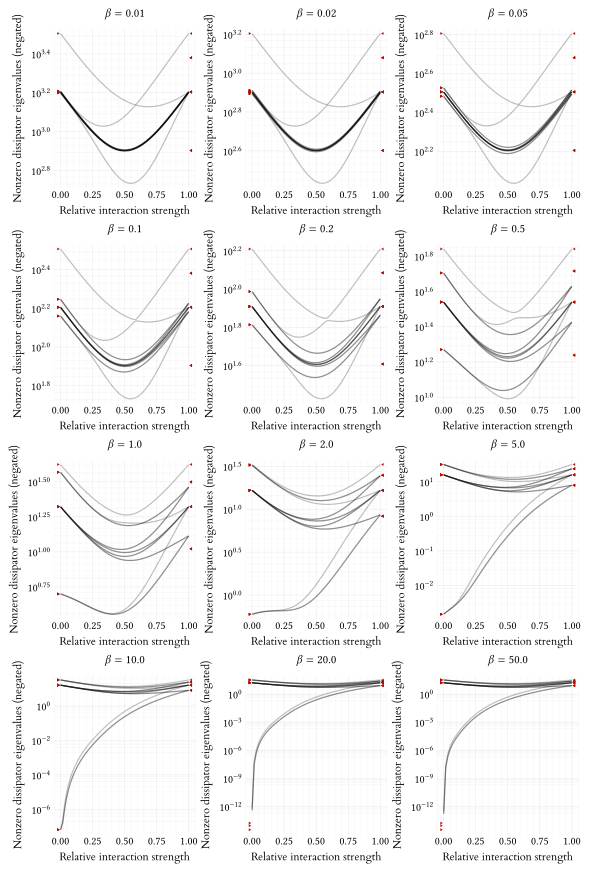

In [679]:
rate_plot(range(1e-3, 1-1e-3, length=64), βs, plot_varrel_rates, xlabel="Relative interaction strength", xscale=:linear)

In [684]:
lgs = range(1e-3, 1-1e-3, length=64)
energies = [eigvals(-(1 - g)*(σx ⊗ₖ σx) - g*(σz ⊗ₖ σ0 + σ0 ⊗ₖ σz)) for g in lgs];

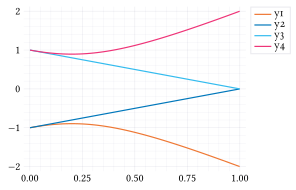

In [685]:
plot(lgs, hcat(energies...)')

In [707]:
using Statistics

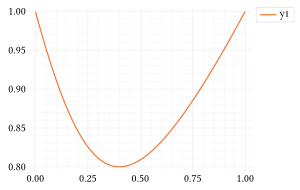

In [712]:
plot(lgs, mean.(map.(x -> abs.(x), energies)))

As $\beta \to 0$, $\gamma$ scales as $\omega^2 / \beta$. To disentangle interaction type from scaling effects, maybe only look at decay rates and eigenvectors for dissipator terms corresponding to each jump operator?